# Executive Summary <br>
- Russia's average temperature was modeled
- Moving average was the model chosen for future predictions
- Temperatures are highly cyclic over months
- Trend of increasing temperatures was observed

# Plan <br>
- Analysis procedure follows the standard data science pipeline
- Obtain data from link in csv format, copy to working directory
- Start at 1900, so we have better quality data (global temp measurments are relatively new to the world)
- NASA website states that accurate global temperature measurements began at around 1880

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

# Acquire

In [2]:
# Data taken from the link below:
# https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

# Get temp data on countries
country_df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
country_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [3]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [4]:
# Find out how many countries we have
country_df.Country.nunique()

243

In [5]:
# Look at the countries that we have data for
country_df.groupby(['Country']).count()

,dt,AverageTemperature,AverageTemperatureUncertainty
Country,,,
Afghanistan,2106,2085,2085
Africa,1965,1894,1894
Albania,3239,3166,3166
Algeria,2721,2702,2702
American Samoa,1761,1629,1629
Andorra,3239,3166,3166
Angola,1878,1728,1728
Anguilla,2277,2086,2086
Antarctica,764,0,739


In [6]:
# Lets use Russia as the country for this mini-project
country_df[country_df.Country == 'Russia'].head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
430275,1812-01-01,-27.114,4.336,Russia
430276,1812-02-01,-25.644,4.394,Russia
430277,1812-03-01,-19.108,4.171,Russia
430278,1812-04-01,-7.605,4.286,Russia
430279,1812-05-01,2.296,3.594,Russia


In [7]:
country_df[country_df.Country == 'Russia'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421 entries, 430275 to 432695
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2421 non-null   object 
 1   AverageTemperature             2405 non-null   float64
 2   AverageTemperatureUncertainty  2405 non-null   float64
 3   Country                        2421 non-null   object 
dtypes: float64(2), object(2)
memory usage: 94.6+ KB


In [8]:
country_df[country_df.Country == 'Russia'].describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,2405.0,-5.521882,14.567358,-30.577,-19.208,-5.178,9.445,16.893
AverageTemperatureUncertainty,2405.0,1.069025,0.975531,0.101,0.243,0.741,1.719,6.257


Takeaways from Acquire: <br>
- dt column is not in date-time type, temp data is float, country data is string
- Numeric temp columns have many nulls
- Country min temp of -37 and max temp of 38 ( 8 and 19 respectively for globe)
- Temp is in degree celcius given the range (38C is 100F, still seems low for max)
- Temp was measured in 243 countries
- Begins in 1743, before accurate temperate measurements were common

# Prepare

In [9]:
# Assume that we did not have accurate global temperature measurements until 1880
# Assumption comes from:
# https://earthobservatory.nasa.gov/world-of-change/global-temperatures

def prepare_temp_data(df):
    
    # set Russia as the only country in our dataframe
    df = country_df[country_df.Country == 'Russia']
    
    # dt column name may cause problems because 'dt' is used to call some methods
    # rename dt column to date
    # give shorter names to other columns too
    df.rename(columns={'dt':'date','AverageTemperature':'temp_avg', 'AverageTemperatureUncertainty':'temp_unc'}, inplace=True)
    
    # set the date to datetime type
    df.date = pd.to_datetime(df.date)
    
    # add columns for year and date
    df['year'] = df.date.dt.year
    #df['month'] = df.date.dt.month
    
    # set index to date
    df = df.set_index('date').sort_index()
    
    # good global temp measurements supposedly began in 1880 (according to NASA website)
    # use 1900 as starting point to improve data integrity and quality
    df = df[df.year >= 1900]
    
    # huge unrealistic spike at last year, so get rid of last year
    df = df[df.year < 2013]
    
    # drop country because Russia is the only country left
    # drop temp_unc because we are looking at temp_avg
    # drop year because I am done using it
    df = df.drop(columns=['Country', 'temp_unc', 'year'])
    
    # fill nulls with previous years info
    # this is conservative because it will slightly slow global warming
    # only 2 nulls out of more than a thousand records
    df = df.fillna(method='bfill', axis=1)
    
    # huge number of time gaps
    # resample to month to close time gaps
    df.resample('M').mean
    
    return df

country_df = prepare_temp_data(country_df)
country_df.head()

,temp_avg
date,
1900-01-01,-29.659
1900-02-01,-23.451
1900-03-01,-14.698
1900-04-01,-6.678
1900-05-01,4.176


In [10]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1356 entries, 1900-01-01 to 2012-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp_avg  1356 non-null   float64
dtypes: float64(1)
memory usage: 21.2 KB


In [11]:
# no nulls after data prep
country_df.isna().sum()

temp_avg    0
dtype: int64

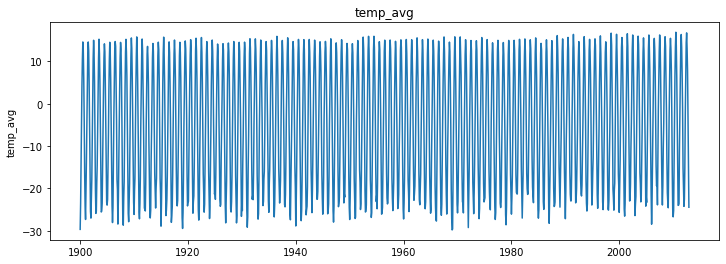

In [12]:
# take a look at the data
for col in country_df.columns:
    plt.figure(figsize=(12,4))
    plt.plot(country_df[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [13]:
# this function checks for gaps in time
def check_gaps(df):
    index_days = df.index.nunique()
    n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
    
    print('Number of rows: ', index_days)
    print('Number of days between first and last day: ', n_days)
    
check_gaps(country_df)

Number of rows:  1356
Number of days between first and last day:  41243 days 00:00:00


In [14]:
# huge number of time gaps, but they appear to be closed off
# after resampling by month
country_df.head(1000)

,temp_avg
date,
1900-01-01,-29.659
1900-02-01,-23.451
1900-03-01,-14.698
1900-04-01,-6.678
1900-05-01,4.176
1900-06-01,10.555
1900-07-01,14.600
1900-08-01,12.545
1900-09-01,5.962


Takeaways for Prepare: <br>
- Only two nulls, which were backfilled
- Many gaps in time, which were closed after resampling by month
- Temp varies between around 10 and -30

# Explore

In [15]:
# split the data
def split_data(df):
    train_size = int(len(df) * 0.5)
    validate_size = int(len(df) * 0.3)
    test_size = int(len(df)) - train_size - validate_size
    validate_end_index = train_size + validate_size
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]
    
    return train, validate, test

train, validate, test = split_data(country_df)
train.shape, validate.shape, test.shape

((678, 1), (406, 1), (272, 1))

In [16]:
train.head()

,temp_avg
date,
1900-01-01,-29.659
1900-02-01,-23.451
1900-03-01,-14.698
1900-04-01,-6.678
1900-05-01,4.176


In [17]:
# verify the splits in the data
# sum of split groups is equal to df
print(len(train) + len(validate) + len(test) == len(country_df))

True


In [18]:
# first row of df is equal to first row of train
print(country_df.head(1) == train.head(1))

            temp_avg
date                
1900-01-01      True


In [19]:
# end of train is adjacent to beginning of validate
pd.concat([train.tail(1), validate.head(1)])

,temp_avg
date,
1956-06-01,12.405
1956-07-01,15.029


In [20]:
# end of validate is adjacent to beginning of test
pd.concat([validate.tail(1), test.head(1)])

,temp_avg
date,
1990-04-01,-2.720
1990-05-01,5.684


In [21]:
# end of test is equal to end of df
print(test.tail(1) == country_df.tail(1))

            temp_avg
date                
2012-12-01      True


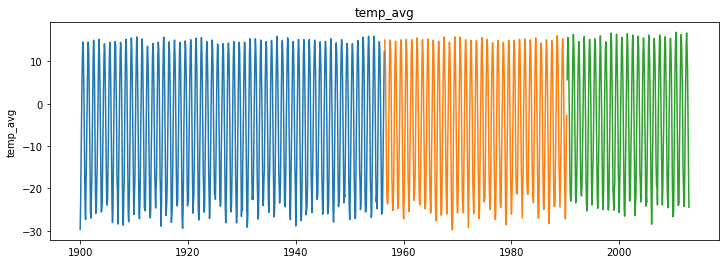

In [22]:
for col in train.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Model

In [23]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [24]:
# plot and evaluate
def plot_and_eval(target_var):
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE : {:.0f}'.format(rmse))
    plt.show()
    

In [25]:
# create a df of evaluation metrics

# create the empty df
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type':[model_type], 'target_var':[target_var], 'rmse':[rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

Last Observed Value Model

In [26]:
# create a baseline value based on last value in train
lov = train['temp_avg'][-1:][0]

yhat_df = pd.DataFrame({'temp_avg':[lov]}, index = validate.index)
yhat_df.head()

,temp_avg
date,
1956-07-01,12.405
1956-08-01,12.405
1956-09-01,12.405
1956-10-01,12.405
1956-11-01,12.405


temp_avg -- RMSE : 23


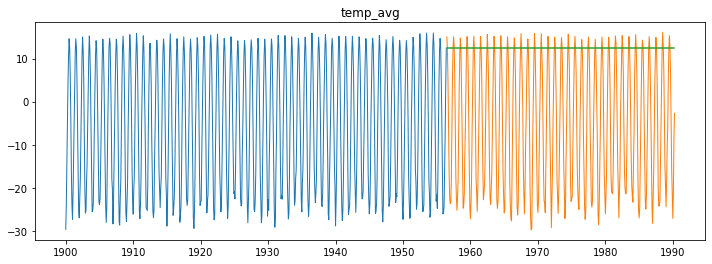

In [27]:
# plot actual and predicted values using loop
for col in train.columns:
    plot_and_eval(col)

In [28]:
# add to evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

Simple Average Model

In [32]:
# make predictions based on simple average
pred = round(train['temp_avg'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'temp_avg':[pred]}, index=validate.index)
    return yhat_df

yhat_df = make_predictions()
yhat_df.head()

,temp_avg
date,
1956-07-01,-5.55
1956-08-01,-5.55
1956-09-01,-5.55
1956-10-01,-5.55
1956-11-01,-5.55


temp_avg -- RMSE : 14


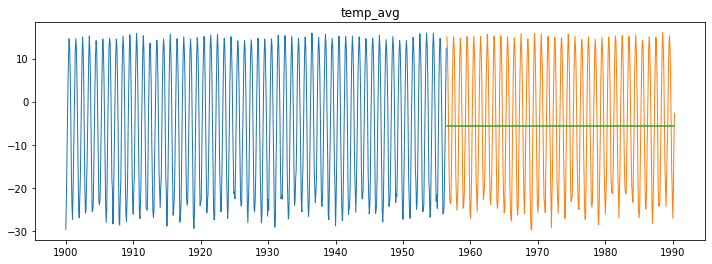

In [33]:
# plot actual vs predictions
for col in train.columns:
    plot_and_eval(col)

In [34]:
# add to evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)

Moving Average Model

In [60]:
# create a 5 year moving average model
# use the last 5 years to predict forwards

period = 5
pred = round(train['temp_avg'].rolling(period).mean().iloc[-1],  2)

yhat_df = make_predictions()
yhat_df.head()

# this is the best model, so save it here as a new variable
yhat_mov = yhat_df

temp_avg -- RMSE : 14


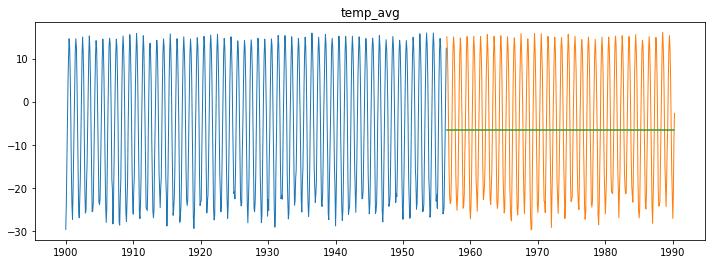

In [61]:
# plot actual vs predicted values
for col in train.columns:
    plot_and_eval(col)

In [51]:
# add to evaluation metrics
for col in train.columns:
    # this line was resampled in textbook example, but I resampled previously
    eval_df = append_eval_df(model_type='moving_average', target_var = col)

Holt's Linear Trend Model

temp_avg 



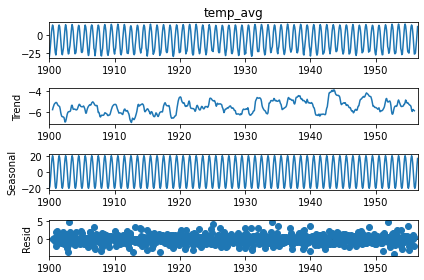

In [52]:
# look at the seasonal decomposition of the target
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col]).plot()
    plt.show()

In [53]:
# make predictions using Holt's method
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1, smoothing_slope=0.1, optimized=False)
    yhat_pred = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_pred, 2)

temp_avg -- RMSE : 26


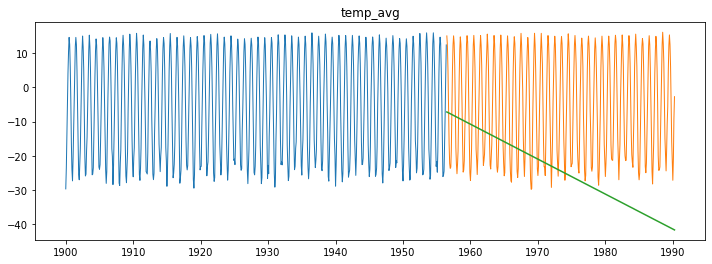

In [54]:
# plot actual vs predicted
for col in train.columns:
    plot_and_eval(target_var = col)

In [55]:
# add to evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type='Holts', target_var = col)

Model Comparison

In [56]:
# get the rmse for each model
min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

# filter the rows to find only those the match the rmse
# to identify the best models
eval_df[((eval_df.rmse == min_rmse))]

,model_type,target_var,rmse
1,simple_average,temp_avg,14.0
2,simple_average,temp_avg,14.0
4,moving_average,temp_avg,14.0
6,moving_average,temp_avg,14.0


Looking at the plots, the moving average model appears the best <br> <br>

In [71]:
# make predictions based on previously used moving average
pred = round(yhat_mov.mean()[0], 2)

def make_predictions():
    yhat_df = pd.DataFrame({'temp_avg':[pred]}, index=test.index)
    return yhat_df

yhat_df = make_predictions()
yhat_df.head()

,temp_avg
date,
1990-05-01,-6.52
1990-06-01,-6.52
1990-07-01,-6.52
1990-08-01,-6.52
1990-09-01,-6.52


temp_avg -- RMSE : 15


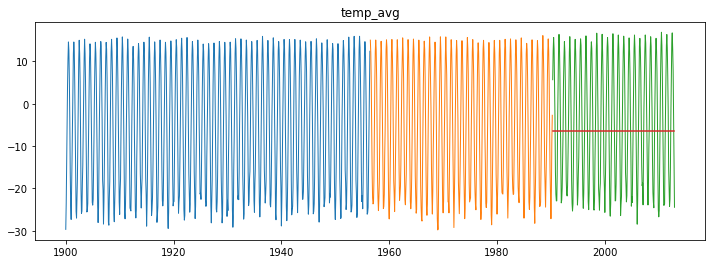

In [75]:
# evaluation function to compute rmse
# the original function was modified to work on the test data set instead of validate
def evaluate_test(target_var):
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    return rmse
    
# plot actual vs predicted
for col in train.columns:
    plot_and_eval_test(target_var = col)

The moving average model predicts that Russia will have future average temperatures of -6.52 degrees celcius

# Conclusion <br>
- Relatively high variation between years, possibly multi-year cyclic to some extent
- Moving average is the best model for predicting temperature trends